# Exercise 2: Distill knowledge from a pre-trained language model to a smaller student model

In machine learning, we often train large, powerful models that achieve high accuracy but are computationally expensive for deployment. Knowledge distillation is a powerful technique to transfer the 'knowledge' from a large "teacher" model to a smaller "student" model. The student learns to mimic the teacher's behavior, often retaining a significant portion of the teacher's performance while being much more efficient.

> **Overview**: We will apply knowledge distillation to compress a pre-trained transformer model by training a smaller student model to reproduce the teacher's soft predictions on a classification task. This will result in a more efficient model suitable for resource-constrained environments.
>
> **Goal**: Implement knowledge distillation to create a smaller language model that maintains high accuracy while being more deployable for tasks like text classification.
>
> **Scenario**: Your SaaS company's support system uses a BERT model to identify duplicate customer tickets. While the system works perfectly, it's an overkill - the task is simple after all: determine if tickets like "Can't login to my account" and "Unable to access my account" are duplicates. And, yet, you are burning thousands in cloud costs for what should be a lightweight operation. So, you decide to simplify the model's architecture via knowledge distillation.
>
> **Tools**: pytorch, transformers, numpy, matplotlib
> <br> _Prior experience with PyTorch and Transformers recommended!_
>
> **Estimated Time**: ~=20 minutes

## Step 1: Setup

First, let's import the necessary libraries and set up our environment.

In [1]:
# # Uncomment to install necessary libraries, then comment out the cell block again and restart the notebook
# ! pip install transformers torch datasets matplotlib tqdm

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
import warnings
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DistilBertForSequenceClassification
from datasets import load_dataset
from tqdm.auto import tqdm
import time

# Suppress warnings
warnings.filterwarnings("ignore")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set up plotting
plt.style.use('ggplot')

# Set the device for pytorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Libraries imported successfully!")
print(f"Using device: {device}")

/home/student/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully!
Using device: cuda


## Step 2: Load the teacher model and dataset

We will use a fine-tuned BERT model as the teacher and a DistilBERT model as the student. DistilBERT is already significantly smaller than BERT, making it a good candidate for the student model. As they both share similar architectures, knowledge transfer is simplified.

We'll load the [MRPC (Microsoft Research Paraphrase Corpus)](https://www.microsoft.com/en-us/download/details.aspx?id=52398) dataset, a common benchmark for paraphrase detection, which is a sequence classification task.

In [3]:
# Load the teacher model (larger BERT-based model)
teacher_model_name = "bert-base-uncased"
teacher_tokenizer = AutoTokenizer.from_pretrained(teacher_model_name)
teacher_model = AutoModelForSequenceClassification.from_pretrained(
    teacher_model_name, 
    num_labels=2
).to(device)

# Load the student model (smaller DistilBERT)
student_model_name = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(student_model_name)
student_model = DistilBertForSequenceClassification.from_pretrained(
    student_model_name,
    num_labels=2
).to(device)

print(f"Teacher model parameters: {sum(p.numel() for p in teacher_model.parameters()):,}")
print(f"Student model parameters: {sum(p.numel() for p in student_model.parameters()):,}")
print(f"Compression ratio: {sum(p.numel() for p in teacher_model.parameters()) / sum(p.numel() for p in student_model.parameters()):.2f}x")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Teacher model parameters: 109,483,778
Student model parameters: 66,955,010
Compression ratio: 1.64x


> **Understanding initialization warnings**: These warnings are expected! Both BERT and DistilBERT are loaded with their pre-trained weights, but the classification heads are randomly initialized since we're adapting them for our specific task. This is why we need to fine-tune the models before using them for predictions.

> **Pros of pre-trained model access**: With just two lines of code, we're loading:
> - **BERT-base**: 110M parameters trained on Wikipedia + BookCorpus
> - **DistilBERT**: 66M parameters distilled from BERT by Hugging Face
> 
> These models understand language structure, context, and semantics from their pre-training. We're just adapting them for our specific sentiment task. Without the transformers library, we'd need to:
> 1. Implement the transformer architecture from scratch
> 2. Download and manage 400MB+ model files manually
> 3. Write custom tokenization code for each model
> 
> The library handles all this complexity with simple, consistent APIs.

In [4]:
# Load the dataset
dataset = load_dataset("SetFit/mrpc", split="train[:1000]")
print(f"Dataset loaded!\nNumber of examples: {len(dataset)}.")
print(f"Features: {dataset.features}")

Repo card metadata block was not found. Setting CardData to empty.


Dataset loaded!
Number of examples: 1000.
Features: {'text1': Value(dtype='string', id=None), 'text2': Value(dtype='string', id=None), 'label': Value(dtype='int64', id=None), 'idx': Value(dtype='int64', id=None), 'label_text': Value(dtype='string', id=None)}


> **Understanding the MRPC dataset**:
> The Microsoft Research Paraphrase Corpus contains pairs of sentences labeled as semantically equivalent (1) or not (0).
> - **Features**: 
>   - `text1`, `text2`: The sentence pairs to compare
>   - `label`: 0 (different meaning) or 1 (same meaning)
>   - `label_text`: Human-readable version ("not_equivalent", "equivalent")
>   - `idx`: Unique identifier for each example
> 
> Also, about the _"Repo card metadata block was not found"_ warning: This warning simply means the dataset doesn't have a README card. It's harmless and doesn't affect the data.

# Step 3: Prepare the data for training

Let's tokenize our dataset and create data loaders for training. 

Like all in-training compression techniques, knowledge distillation requires access to training data to teach the student model.

In [5]:
def tokenize_data(dataset, tokenizer, max_length=128):
    """Tokenize text data for model input."""
    # MRPC dataset uses text1 and text2, not sentence1 and sentence2
    texts = [ex["text1"] + " [SEP] " + ex["text2"] for ex in dataset]
    labels = [ex["label"] for ex in dataset]
    
    # Tokenize all texts
    encoded = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )
    
    return encoded, torch.tensor(labels)

# Tokenize data for both models
teacher_data, labels = tokenize_data(dataset, teacher_tokenizer)
student_data, _ = tokenize_data(dataset, student_tokenizer)

# Create data loaders
batch_size = 16
teacher_dataset = TensorDataset(
    teacher_data["input_ids"],
    teacher_data["attention_mask"],
    labels
)
student_dataset = TensorDataset(
    student_data["input_ids"],
    student_data["attention_mask"],
    labels
)

teacher_loader = DataLoader(teacher_dataset, batch_size=batch_size, shuffle=True)
student_loader = DataLoader(student_dataset, batch_size=batch_size, shuffle=True)

print(f"Data prepared: {len(teacher_loader)} batches")

Data prepared: 63 batches


> **Data flow in distillation**:
> ```
> Original Text → BERT Tokenizer → Teacher Model → Soft Predictions ↘
>                                                                    → Distillation Loss
> Original Text → DistilBERT Tokenizer → Student Model → Predictions ↗
> ```
> Both models see the same text but process it through their own tokenization pipelines.

# Step 4: Implement the knowledge distillation loss

The core of knowledge distillation is the loss function. We need to implement a loss that combines:
1. The standard cross-entropy loss against true labels (hard targets)
2. The KL divergence between teacher and student predictions (soft targets)

In [6]:
class DistillationLoss(nn.Module):
    def __init__(self, temperature=3.0, alpha=0.7):
        super().__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss()
    
    def forward(self, student_logits, teacher_logits, labels):
        # TODO: Calculate the soft targets from logits for the teacher  using temperature
        # Hint: Which PyTorch activation function converts logits to probabilities? How do you incorporate temperature?
        # Find options at https://docs.pytorch.org/docs/stable/nn.functional.html#non-linear-activation-functions
        # Consider using different ones for teacher and student too!
        teacher_soft = F.softmax(teacher_logits / self.temperature, dim=1)  # Add your code here
        student_soft = F.log_softmax(student_logits / self.temperature, dim=1)  # Add your code here
        
        # TODO: Calculate distillation loss
        # Hint: Which PyTorch loss function measures divergence between two probability distributions?
        # Find options at https://docs.pytorch.org/docs/stable/nn.functional.html#loss-functions
        # Also, you should scale by temperature^2 as per the original paper
        distillation_loss = F.kl_div(
            student_soft,
            teacher_soft,
            reduction='batchmean'
        ) * (self.temperature ** 2)  # Add your code here
        
        # TODO: Calculate the loss with hard labels for the student
        # Hint: What's the typical loss for classification? Note that we have set it up in our __init__ to support each forward pass
        # Find options at https://docs.pytorch.org/docs/stable/nn.functional.html#loss-functions
        hard_loss = self.ce_loss(student_logits, labels)  # Add your code here
        
        # TODO: Combine both losses with alpha weighting
        #  How do you balance two losses? One gets α weight, the other gets (1-α)
        combined_loss = self.alpha * distillation_loss + (1 - self.alpha) * hard_loss  # Add your code here
        
        return combined_loss, distillation_loss, hard_loss

# Initialize the distillation loss
criterion = DistillationLoss(temperature=3.0, alpha=0.7)
print("Distillation loss initialized!")

Distillation loss initialized!


> **Understanding temperature in distillation**: Temperature is a crucial hyperparameter in knowledge distillation. Higher temperatures (T > 1) "soften" the probability distributions, making small differences between classes more pronounced. This helps the student learn the nuanced relationships between classes that the teacher has discovered. A temperature of 3.0 is a good starting point, but you may need to tune this based on your specific task.
> 
> Let's take this sentence pair as an exmaple: "Great movie!" vs "Excellent film!"
> 
>   - _Without temperature (T=1)_:  
>   Teacher output: [0.02, 0.98] (very confident: same sentiment)    
>   Student learns: "These are definitely the same"
> <br><br>
>   - _With temperature (T=3)_:  
>   Teacher output: [0.15, 0.85] (confident but nuanced)  
>   Student learns: "These are likely the same, but there's slight uncertainty"
> 
> The temperature-softened distribution teaches the student about the teacher's uncertainty and edge cases!

## Step 5: Implement the model training loop

Now we'll implement the training loop that teaches the student model to mimic the teacher's behavior. This is where the actual knowledge transfer happens.

**Important**: The training configuration is hard-coded, but feel free to experiment with any training parameter!

In [7]:
# Let's define the number of epochs
num_epochs = 3

In [8]:
# First, let's fine-tune the teacher model on our task (for fair comparison)
print("Fine-tuning the teacher model first...")

def train_teacher(model, train_loader, device, num_epochs):
    """Fine-tune the teacher model on the task."""
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        progress_bar = tqdm(train_loader, desc=f'Teacher Epoch {epoch+1}/{num_epochs}')
        total_loss = 0
        correct = 0
        total = 0
        
        for input_ids, attention_mask, labels in progress_bar:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            accuracy = 100 * correct / total
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{accuracy:.2f}%'
            })
        
        avg_loss = total_loss / len(train_loader)
        print(f"Teacher Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    return model

# Fine-tune the teacher first
teacher_model = train_teacher(teacher_model, teacher_loader, device, num_epochs=num_epochs)
print("\nTeacher model fine-tuned!")

Fine-tuning the teacher model first...


Teacher Epoch 1/3: 100%|██████████| 63/63 [00:16<00:00,  3.93it/s, loss=0.3965, acc=66.50%]


Teacher Epoch 1 - Loss: 0.6115, Accuracy: 66.50%


Teacher Epoch 2/3: 100%|██████████| 63/63 [00:15<00:00,  3.96it/s, loss=0.2106, acc=77.50%]


Teacher Epoch 2 - Loss: 0.4849, Accuracy: 77.50%


Teacher Epoch 3/3: 100%|██████████| 63/63 [00:16<00:00,  3.90it/s, loss=0.1424, acc=88.20%]

Teacher Epoch 3 - Loss: 0.3080, Accuracy: 88.20%

Teacher model fine-tuned!


> **Why fine-tune the teacher first?**
> - Pre-trained BERT knows general language but not our specific task
> - Fine-tuning creates task-specific knowledge to transfer
> - Without this, we'd be distilling general language understanding only
> 
> And, we can see how the teacher becomes an "expert" at movie review sentiment across training epochs:
> - Epoch 1 (66.5%): Learning basic sentiment patterns
> - Epoch 2 (77.5%): Refining decision boundaries
> - Epoch 3 (88.2%): Achieving strong task performance

In [9]:
def train_with_distillation(student_model, teacher_model, train_loader, criterion, 
                           optimizer, device, num_epochs):
    """Train student model using knowledge distillation from teacher model."""
    
    # TODO: Make sure the teacher does not train
    # Hint: We want consistent predictions from the teacher - which mode prevents dropout and batch norm updates?
    teacher_model.eval()  # Add your one-line code here
    
    training_history = {
        'total_loss': [],
        'distillation_loss': [],
        'hard_loss': [],
        'accuracy': []
    }
    
    for epoch in range(num_epochs):
        student_model.train()
        epoch_losses = {'total': 0, 'distillation': 0, 'hard': 0}
        correct = 0
        total = 0
        
        # Create progress bar for batches
        progress_bar = tqdm(enumerate(train_loader), 
                           total=len(train_loader),
                           desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for batch_idx, (input_ids, attention_mask, labels) in progress_bar:
            # Move data to device
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)
            
            # TODO: Get teacher predictions (no gradients needed)
            # Hint: Use torch.no_grad() context and forward pass through teacher
            with torch.no_grad():
                teacher_outputs = teacher_model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )  # Add your code here
                teacher_logits = teacher_outputs.logits  # Add your code here
            
            # TODO: Get student predictions
            # Hint: Forward pass through student model
            student_outputs = student_model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )  # Add your code here
            student_logits = student_outputs.logits  # Add your code here
            
            # TODO: Calculate distillation loss
            # Hint: Use the criterion we defined earlier
            loss, distill_loss, hard_loss = criterion(
                student_logits, teacher_logits, labels
            )  # Add your code here
            
            # Standard backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track metrics
            epoch_losses['total'] += loss.item()
            epoch_losses['distillation'] += distill_loss.item()
            epoch_losses['hard'] += hard_loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(student_logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar
            current_acc = 100 * correct / total
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{current_acc:.2f}%'
            })
        
        # Record epoch metrics
        avg_losses = {k: v/len(train_loader) for k, v in epoch_losses.items()}
        accuracy = 100 * correct / total
        
        training_history['total_loss'].append(avg_losses['total'])
        training_history['distillation_loss'].append(avg_losses['distillation'])
        training_history['hard_loss'].append(avg_losses['hard'])
        training_history['accuracy'].append(accuracy)
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Average Total Loss: {avg_losses['total']:.4f}")
        print(f"Average Distillation Loss: {avg_losses['distillation']:.4f}")
        print(f"Average Hard Loss: {avg_losses['hard']:.4f}")
        print(f"Accuracy: {accuracy:.2f}%\n")
    
    return training_history

# Set up optimizer for student model
optimizer = torch.optim.AdamW(student_model.parameters(), lr=2e-5)

# Train the student model
print("Starting knowledge distillation training...")
history = train_with_distillation(
    student_model, teacher_model, student_loader, 
    criterion, optimizer, device, num_epochs=num_epochs
)

Starting knowledge distillation training...


Epoch 1/3: 100%|██████████| 63/63 [00:13<00:00,  4.80it/s, loss=0.2242, acc=65.90%]



Epoch 1 Summary:
Average Total Loss: 0.5915
Average Distillation Loss: 0.5720
Average Hard Loss: 0.6371
Accuracy: 65.90%



Epoch 2/3: 100%|██████████| 63/63 [00:13<00:00,  4.85it/s, loss=0.4459, acc=74.30%]



Epoch 2 Summary:
Average Total Loss: 0.4001
Average Distillation Loss: 0.3509
Average Hard Loss: 0.5147
Accuracy: 74.30%



Epoch 3/3: 100%|██████████| 63/63 [00:12<00:00,  4.88it/s, loss=0.1015, acc=88.20%]


Epoch 3 Summary:
Average Total Loss: 0.1738
Average Distillation Loss: 0.1244
Average Hard Loss: 0.2893
Accuracy: 88.20%



> **Recap: Distillation training strategy**:
> 1. *Teacher in eval mode*: No dropout, stable predictions
> 2. *Two forward passes*: Teacher (no grad) + Student (with grad)
> 3. *Complex loss*: Balancing soft targets and hard labels
> 4. *Progress tracking*: Monitoring three losses instead of one
> 
> So, we can summarize the knowledge transfer process as follows:
> ```
> Teacher (frozen) → Consistent soft predictions
>                    ↓
> Student (learning) → Tries to match teacher's confidence patterns
>                    ↓
> Loss backprop → Student parameters update
> ```

## Step 6: Visualize the training history

Let's visualize how the different loss components evolve during training to understand how the student learns from the teacher.

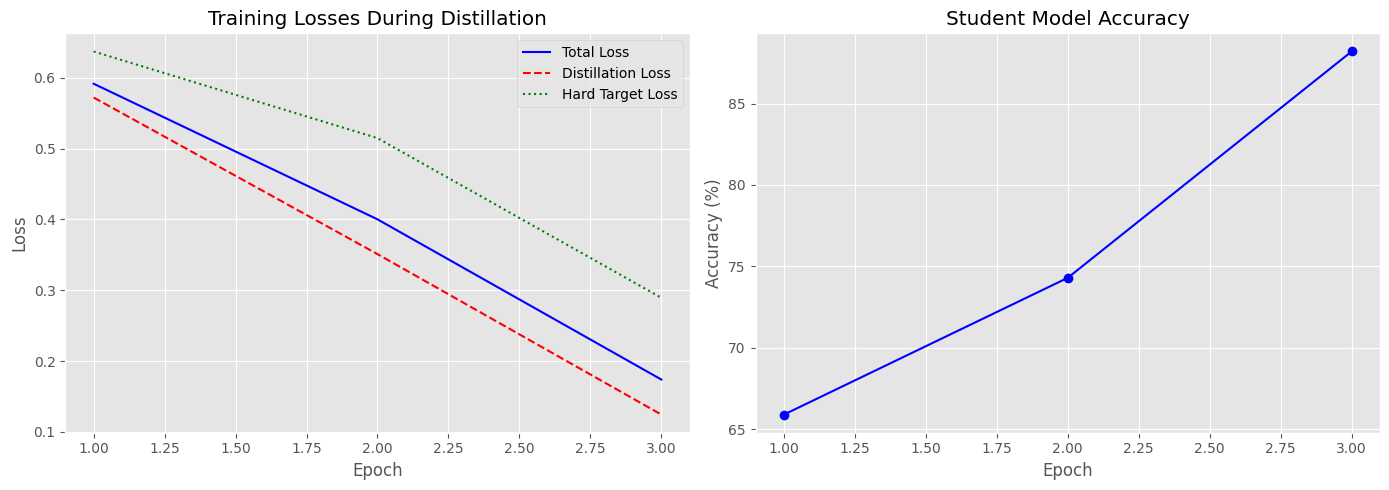

Final student accuracy: 88.20%


In [10]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot losses
# TODO: Define losses
# Hint: This information is stored in the model training `history`!
total_loss, distillation_loss, hard_loss =  history['total_loss'], history['distillation_loss'], history['hard_loss']   # Add your code here
epochs = range(1, len(total_loss) + 1)
ax1.plot(epochs, total_loss, 'b-', label='Total Loss')
ax1.plot(epochs, distillation_loss, 'r--', label='Distillation Loss')
ax1.plot(epochs, hard_loss, 'g:', label='Hard Target Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Losses During Distillation')
ax1.legend()
ax1.grid(True)

# Plot accuracy
ax2.plot(epochs, history['accuracy'], 'b-', marker='o')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Student Model Accuracy')
ax2.grid(True)

plt.tight_layout()
plt.show()

print(f"Final student accuracy: {history['accuracy'][-1]:.2f}%")

> **Interpreting the loss curves**: The visualization shows how the student balances learning from both the teacher (distillation loss) and the true labels (hard loss). Initially, the distillation loss dominates as the student learns the teacher's behavior patterns. As training progresses, both losses decrease, indicating the student is successfully learning to mimic the teacher while maintaining accuracy on the actual task.
> 
> Both the teacher and student model in this example have not converged; so, in reality, you'd train for more and see even further performance improvements!

# Step 7: Compare student vs teacher performance

Now let's evaluate both models to see how much performance the student retained while being significantly smaller. Then, let's visualize it to better understand tradeoffs.

In [11]:
def evaluate_model(model, tokenizer, dataset_split, device):
    """Evaluate model performance on a dataset with consistent preprocessing."""
    model.eval()
    correct = 0
    total = 0
    total_time = 0
    
    # Create a proper test set
    test_texts = []
    test_labels = []
    
    for example in dataset_split:
        test_texts.append(example["text1"] + " [SEP] " + example["text2"])
        test_labels.append(example["label"])
    
    # Process in batches
    batch_size = 16
    num_batches = 0
    
    for i in range(0, len(test_texts), batch_size):
        batch_texts = test_texts[i:i+batch_size]
        batch_labels = test_labels[i:i+batch_size]
        
        # Tokenize for this specific model
        inputs = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt"
        ).to(device)
        
        batch_labels_tensor = torch.tensor(batch_labels).to(device)
        
        with torch.no_grad():
            start_time = time.time()
            outputs = model(**inputs)
            end_time = time.time()
            
            total_time += (end_time - start_time)
            num_batches += 1
            
            _, predicted = torch.max(outputs.logits, 1)
            total += len(batch_labels)
            correct += (predicted == batch_labels_tensor).sum().item()
    
    accuracy = 100 * correct / total
    avg_time = (total_time / num_batches) * 1000  # ms per batch
    
    return accuracy, avg_time

# Create the test split
test_split = dataset.select(range(800, 1000))

print("Evaluating both models on the same test set...")
teacher_acc, teacher_time = evaluate_model(teacher_model, teacher_tokenizer, 
                                               test_split, device)
student_acc, student_time = evaluate_model(student_model, student_tokenizer, 
                                               test_split, device)

# Calculate compression metrics
# TODO: Calculate the parameter reduction percentage
# Hint: Parameter reduction = (1 - student_params/teacher_params) * 100
# See: https://docs.pytorch.org/docs/stable/generated/torch.nn.Module.html and https://docs.pytorch.org/docs/stable/generated/torch.numel.html 
param_reduction = (1 - sum(p.numel() for p in student_model.parameters()) / 
                   sum(p.numel() for p in teacher_model.parameters())) * 100  # Add your code here
speed_improvement = (teacher_time - student_time) / teacher_time * 100
accuracy_change = student_acc - teacher_acc

print("\nModel Comparison:")
print(f"Teacher accuracy: {teacher_acc:.2f}%")
print(f"Student accuracy: {student_acc:.2f}%")
print(f"Teacher inference time: {teacher_time:.2f} ms/batch")
print(f"Student inference time: {student_time:.2f} ms/batch")
print(f"\nCompression Results:")
print(f"Parameter reduction: {param_reduction:.1f}%")
print(f"Speed improvement: {speed_improvement:.1f}%")
print(f"Accuracy change: +{accuracy_change:.2f}%") if accuracy_change >= 0 else print(f"Accuracy change: {accuracy_change:.2f}%")

Evaluating both models on the same test set...

Model Comparison:
Teacher accuracy: 97.00%
Student accuracy: 98.00%
Teacher inference time: 11.06 ms/batch
Student inference time: 5.61 ms/batch

Compression Results:
Parameter reduction: 38.8%
Speed improvement: 49.2%
Accuracy change: +1.00%


> **Can the student overcome the teacher?**: It is unusual, but it can happen! Reasons include:
>   - Small test set (200 examples) -> High variance
>   - Regularization effect of distillation
>   - Lucky initialization for student model
>   - Teacher model not converged yet

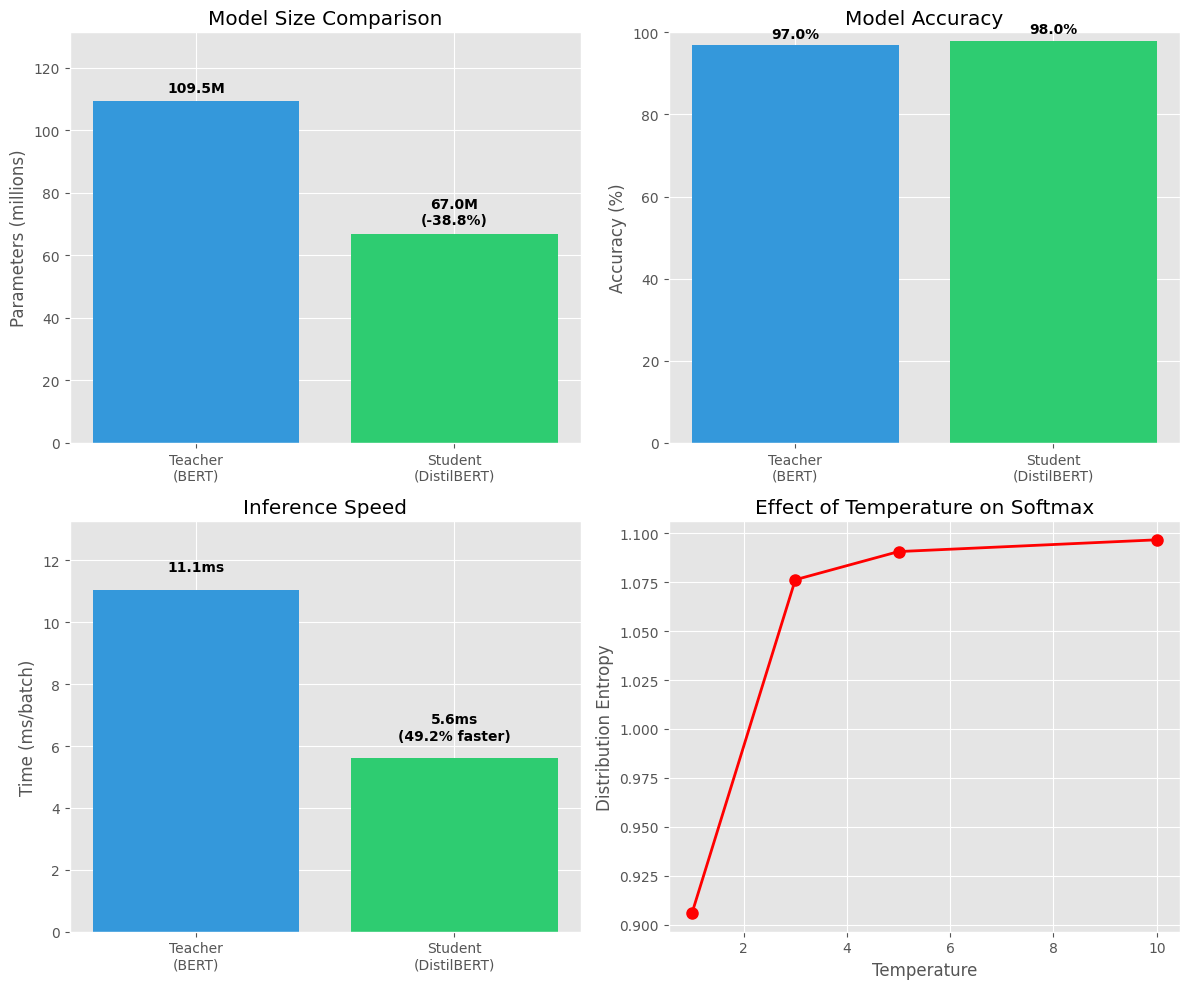

In [12]:
# Create comparison visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))

# Model size comparison
models = ['Teacher\n(BERT)', 'Student\n(DistilBERT)']
sizes = [
    sum(p.numel() for p in teacher_model.parameters()) / 1e6,
    sum(p.numel() for p in student_model.parameters()) / 1e6
]
ax1.bar(models, sizes, color=['#3498db', '#2ecc71'])
ax1.set_ylabel('Parameters (millions)')
ax1.set_title('Model Size Comparison')
ax1.set_ylim(0, max(sizes) * 1.2)

# Add percentage labels
for i, size in enumerate(sizes):
    if i == 1:
        reduction = (1 - sizes[1]/sizes[0]) * 100
        ax1.text(i, size + 2, f'{size:.1f}M\n(-{reduction:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')
    else:
        ax1.text(i, size + 2, f'{size:.1f}M', 
                ha='center', va='bottom', fontweight='bold')

# Accuracy comparison
accuracies = [teacher_acc, student_acc]
ax2.bar(models, accuracies, color=['#3498db', '#2ecc71'])
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Model Accuracy')
ax2.set_ylim(0, 100)

# Add accuracy labels
for i, acc in enumerate(accuracies):
    ax2.text(i, acc + 1, f'{acc:.1f}%', 
            ha='center', va='bottom', fontweight='bold')

# Inference time comparison
times = [teacher_time, student_time]
ax3.bar(models, times, color=['#3498db', '#2ecc71'])
ax3.set_ylabel('Time (ms/batch)')
ax3.set_title('Inference Speed')
ax3.set_ylim(0, max(times) * 1.2)

# Add time labels
for i, time in enumerate(times):
    if i == 1:
        speedup = (times[0] - times[1]) / times[0] * 100
        ax3.text(i, time + 0.5, f'{time:.1f}ms\n({speedup:.1f}% faster)', 
                ha='center', va='bottom', fontweight='bold')
    else:
        ax3.text(i, time + 0.5, f'{time:.1f}ms', 
                ha='center', va='bottom', fontweight='bold')

# Temperature effect visualization
temperatures = [1.0, 3.0, 5.0, 10.0]
softmax_diffs = []

# Simulate the effect of temperature on probability distributions
sample_logits = torch.tensor([2.0, 1.0, 0.5])
for temp in temperatures:
    soft_probs = F.softmax(sample_logits / temp, dim=0)
    # Calculate entropy as a measure of distribution smoothness
    entropy = -(soft_probs * torch.log(soft_probs + 1e-8)).sum().item()
    softmax_diffs.append(entropy)

ax4.plot(temperatures, softmax_diffs, 'ro-', linewidth=2, markersize=8)
ax4.set_xlabel('Temperature')
ax4.set_ylabel('Distribution Entropy')
ax4.set_title('Effect of Temperature on Softmax')
ax4.grid(True)

plt.tight_layout()
plt.show()

> **Understanding temperature in distillation**: Temperature (T) is a scaling factor that "softens" probability distributions. The graph above simulates temperature effects in distillation by applying different T values (1.0-10.0) to sample logits [2.0, 1.0, 0.5] and measuring the resulting entropy. Higher temperatures create flatter distributions, revealing more of the teacher's "dark knowledge" for the student to learn. Higher entropy means more nuanced information available for the student to learn from.
> 
> **Brainstorming stop**: How much money could this compression save? Well, it depends on the requests pattern!
> If you're curious, try to pick a cloud provider and check what the final cost saving for 50k queries/day could look like!
> 
> 💡 *Hint*: Cloud providers often charge by compute-hour. So, you need to carefully choose your deployment machine type.

## Step 8: Test with some example queries

Let's test both models on some example support queries to see how they perform in practice.

In [13]:
# Test on example queries
test_queries = [
    ("I can't log into my account", "Unable to access my account"),
    ("Password reset isn't working", "Can't reset my password"),
    ("App crashes on startup", "Application fails to launch"),
    ("Subscription won't cancel", "Unable to unsubscribe"),
    ("Feature request: dark mode", "Please add dark theme option"),
    ("Billing error this month", "Incorrect charge on my bill"),
    ("Can't upload large files", "File upload fails for big documents"),
    ("Missing export button", "Where is the download option?"),
    ("Account locked after update", "Software update locked me out"),
    ("Refund still not received", "Where's my money back?")
]

print("Testing on customer support ticket pairs:\n")

for i, (query1, query2) in enumerate(test_queries):
    print(f"Query pair {i+1}:")
    print(f"Q1: {query1}")
    print(f"Q2: {query2}")
    
    # Tokenize for both models
    teacher_inputs = teacher_tokenizer(
        query1 + " [SEP] " + query2,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    student_inputs = student_tokenizer(
        query1 + " [SEP] " + query2,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(device)
    
    # Get predictions
    with torch.no_grad():
        teacher_output = teacher_model(**teacher_inputs)
        student_output = student_model(**student_inputs)
        
        teacher_probs = F.softmax(teacher_output.logits, dim=1)
        student_probs = F.softmax(student_output.logits, dim=1)
        
        teacher_pred = torch.argmax(teacher_probs).item()
        student_pred = torch.argmax(student_probs).item()
    
    labels = ["Different", "Similar"]
    print(f"Teacher: {labels[teacher_pred]} (confidence: {teacher_probs[0][teacher_pred]:.3f})")
    print(f"Student: {labels[student_pred]} (confidence: {student_probs[0][student_pred]:.3f})")
    print()

Testing on customer support ticket pairs:

Query pair 1:
Q1: I can't log into my account
Q2: Unable to access my account
Teacher: Similar (confidence: 0.582)
Student: Similar (confidence: 0.512)

Query pair 2:
Q1: Password reset isn't working
Q2: Can't reset my password
Teacher: Similar (confidence: 0.679)
Student: Similar (confidence: 0.834)

Query pair 3:
Q1: App crashes on startup
Q2: Application fails to launch
Teacher: Similar (confidence: 0.590)
Student: Similar (confidence: 0.779)

Query pair 4:
Q1: Subscription won't cancel
Q2: Unable to unsubscribe
Teacher: Different (confidence: 0.659)
Student: Different (confidence: 0.802)

Query pair 5:
Q1: Feature request: dark mode
Q2: Please add dark theme option
Teacher: Different (confidence: 0.564)
Student: Similar (confidence: 0.761)

Query pair 6:
Q1: Billing error this month
Q2: Incorrect charge on my bill
Teacher: Different (confidence: 0.708)
Student: Different (confidence: 0.638)

Query pair 7:
Q1: Can't upload large files
Q2: F

> **Nice, distillation worked!** The student learned the teacher's style but kept some independence. 
> Their answers almost always coincide, with exception of some nuanced use cases.
> 
> What's interesting is looking at confidence levels too. The student seems to have learned to be:
> - More decisive on technical terminology (password, app, crashes)
> - More hesitant on conceptual differences (upload vs files, export vs download)
> 
> Through distillation, the student developed its own "personality" while still matching the teacher's overall accuracy. It's like teaching someone chess and they develop their own playing style!
> 
> _How would you handle this for real use?_ You'd definetely run more extensive testing! And, then, a good strategy could be to auto-merge anything over 70% confidence and let humans handle the rest.

## Conclusion

In this exercise, you've learned how to:
* Implement knowledge distillation loss functions combining soft and hard targets
* Train student models to mimic teacher behavior through temperature-scaled predictions
* Balance distillation and ground truth losses using alpha weighting
* Create smaller models that preserve teacher's nuanced understanding
* Evaluate compression trade-offs between model size, speed, and accuracy

These skills allow you to create inherently efficient models through training-time compression, rather than post-hoc optimization. Knowledge distillation is particularly valuable when changing architectures (BERT to DistilBERT) or when preserving subtle task understanding is critical for production quality.